# Mask R-CNN - HandTrackingThroughDetection

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import cv2

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases


/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.

## Configurations

In [3]:
class handConfig(Config):
    
    NAME = "hand"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  
    STEPS_PER_EPOCH = 1000
    # DETECTION_MIN_CONFIDENCE = 0.1
    # RPN_NMS_THRESHOLD = 0.1

    # DETECTION_NMS_THRESHOLD = 0.1
    # tf.global_variables_initializer()



class InferenceConfig(handConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

def load_model_custom(config):
#     with tf.device(DEVICE):

    model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./model')
    model.load_weights('./model/trained_weights.h5', by_name=True)
        # print(model.summary())

    return model
model = load_model_custom(InferenceConfig())





(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)



(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


## Notebook Preferences

In [4]:
gt_class_id = [0,1]

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Run Detection

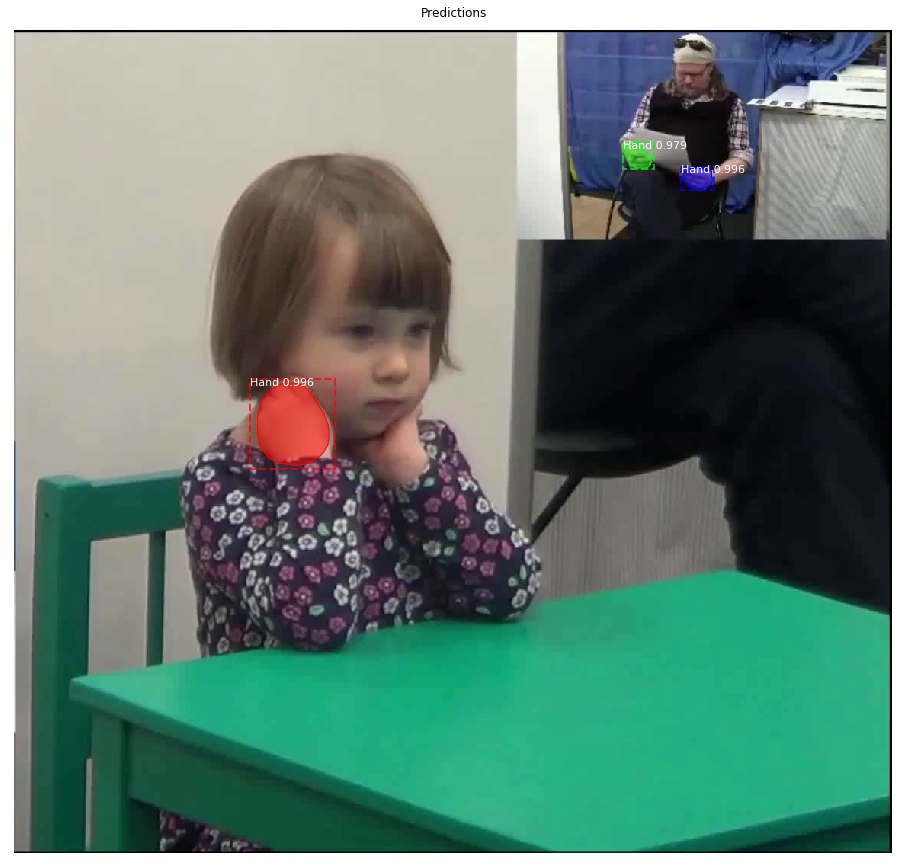

In [6]:
frame_path = "/scratch/shri/Projects/Hand-CNN/frame_output/Frame0.jpg"
image = skimage.io.imread(frame_path)
frames = []
# for files in os.listdir(frame_path)[:2]:
#     print(files)
#     frames.append(skimage.io.imread(frame_path+files)) 
# image = cv2.imread(frame_path)
# print(image)
# img_origin = skimage.io.imread(frame_path)
# img = img_origin.copy()
# print(np.shape(img))

# for frame in frames:
    
results = model.detect([image], verbose=0)

# results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["BG","Hand"], r['scores'], ax=ax,
                            title="Predictions")


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [7]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

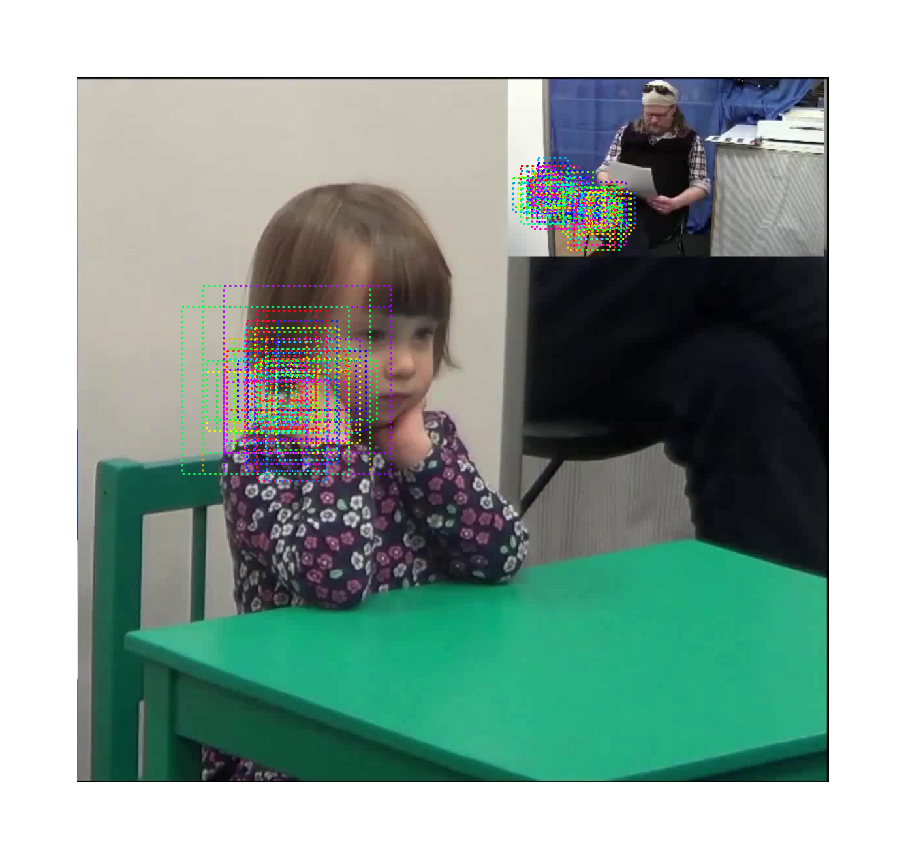

In [19]:
# Show top anchors by score (before refinement)
limit = 400
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

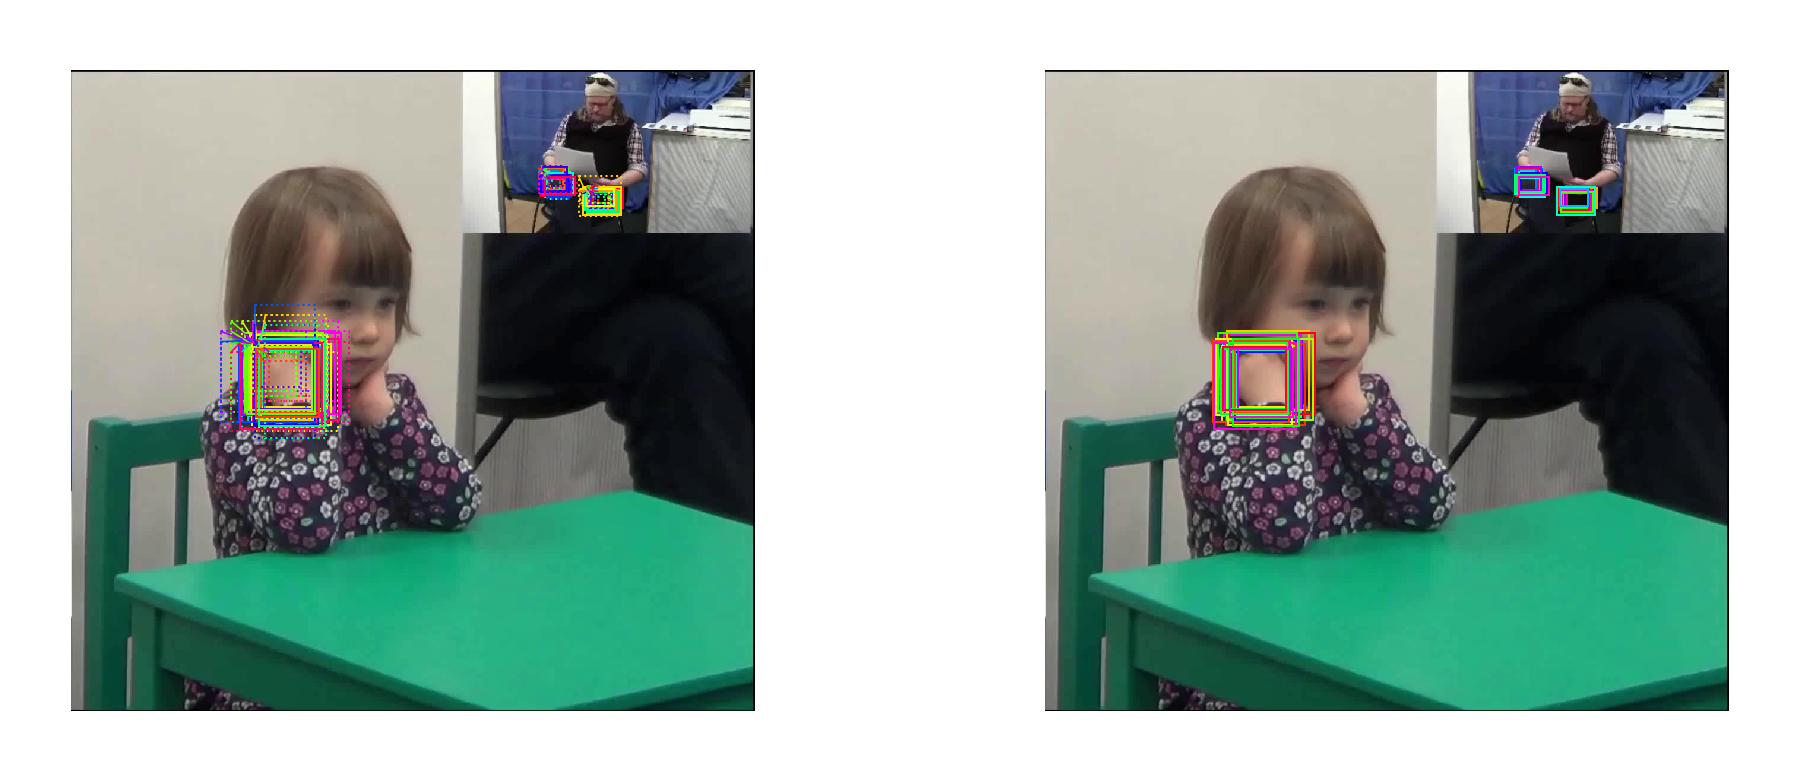

In [17]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 100
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

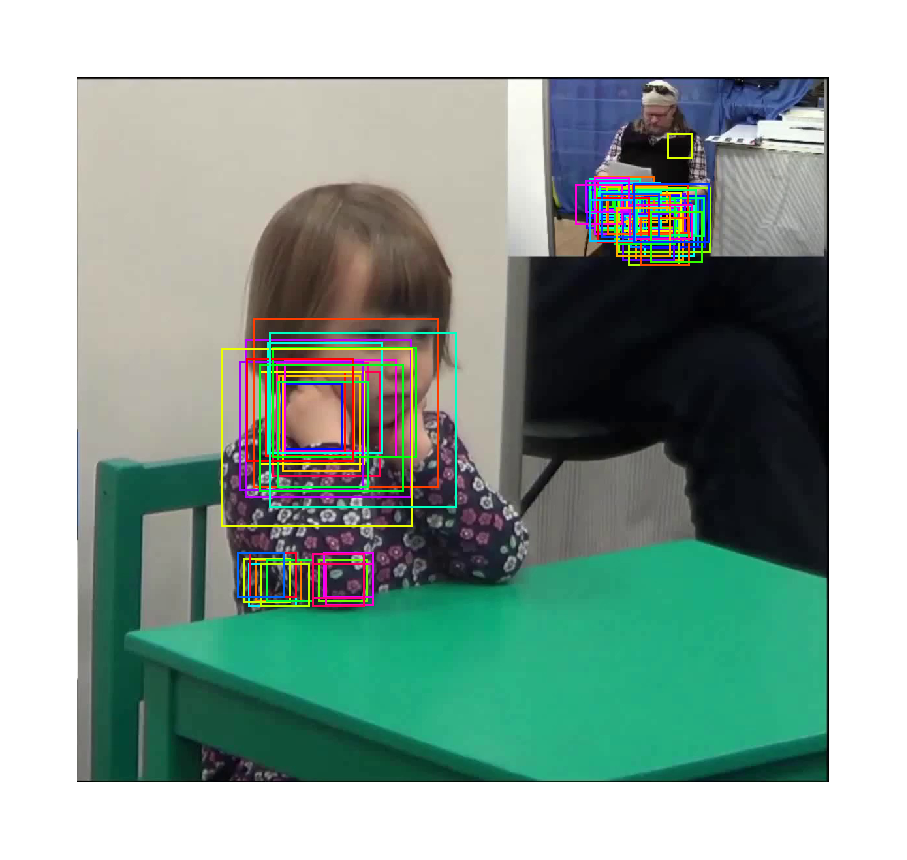

In [16]:
# Show refined anchors after non-max suppression
limit = 100
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())



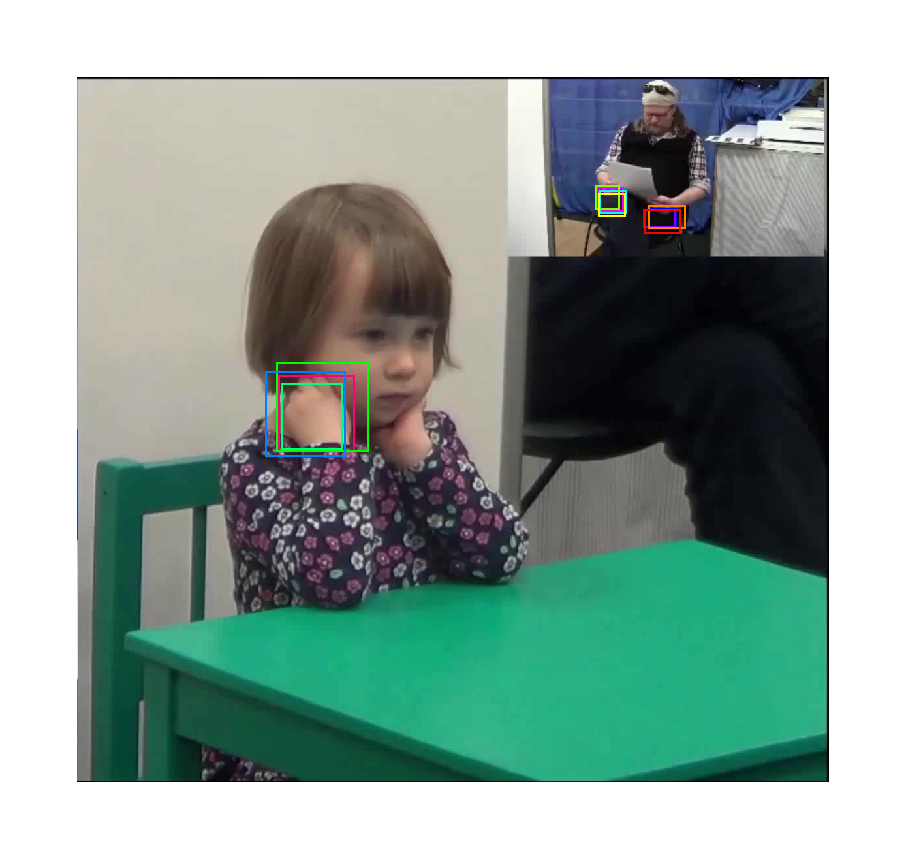

In [20]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 12
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2])
# proposals = rpn['proposals'][0, :limit] * np.array([w, h, w, h])
# print(proposals)

visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

In [90]:
# a = model.run_graph([image], [
#     ("b_boxes",model.keras_model.get_layer("roi_align_classifier").output)])

# mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_orientation=\
#                 fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
#                                      config.POOL_SIZE, config.NUM_CLASSES,
#                                      train_bn=config.TRAIN_BN,
#                                      fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

In [95]:
# print(a.keys())
# # a["b_boxes"]

odict_keys(['b_boxes'])


### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [120]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [188]:
limit = 1000
proposals = utils.denorm_boxes(mrcnn['proposals'][0, :limit], image.shape[:2])

roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]
# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))



# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))
# visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())


### Refinement

roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)#.astype(np.int32)

1000 Valid proposals out of 1000
53 Positive ROIs
Keep 53 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  38  41  43  46  54  55  60  61  62  65  87  88  94 181 242 573]
Remove boxes below 0.7 confidence. Keep 48:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  38  41  43  54  55  60  61  62  65  87  94 242]
[('BG', 947), ('Hand', 53)]


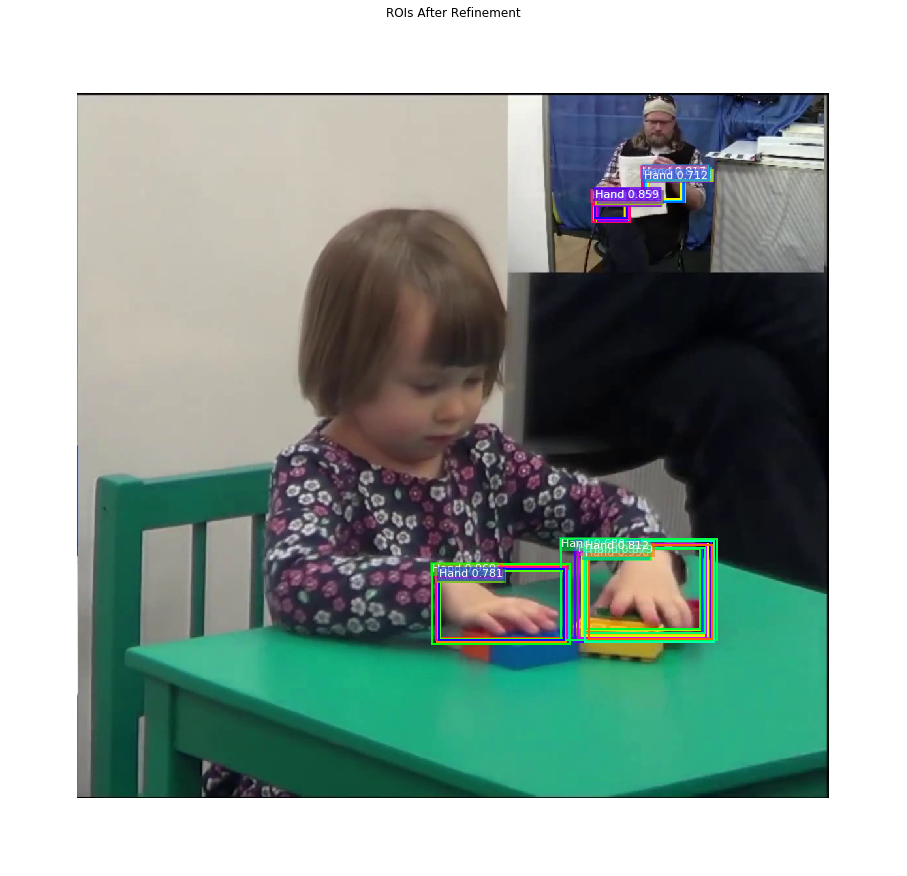

In [189]:
# Show positive proposals
limit = 30
ids = np.arange(0, len(keep)-1)  # Display all
# ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
# ids = roi_positive_ixs[:-1]
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]

# keep = np.where(roi_class_ids > 0)[0]
# print("Keep {} detections:\n{}".format(keep.shape[0], keep))
# keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
# print("Remove boxes below {} confidence. Keep {}:\n{}".format(
#     config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))


# ids = keep
# visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
#                      refined_boxes=refined_proposals[roi_positive_ixs][ids],
#                      visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
#                      captions=captions, title="ROIs After Refinement",
#                      ax=get_ax())

visualize.draw_boxes(image, 
                     refined_boxes=refined_proposals[keep][ids],
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [108]:
# # captions = ["{} {:.3f}".format(str(c), s) for c, s in zip(mrcnn["deltas"][0][:5], mrcnn["probs"][0][:5])]
# # print(captions)
# print(len(mrcnn["probs"][0]))
# a = utils.denorm_boxes(mrcnn["deltas"][0],image.shape[:2])

# for c, s in zip(utils.denorm_boxes(a[:2], mrcnn["probs"][0][:2])):
#                 print(c,s)
            
            
                                                                    

1000


ValueError: operands could not be broadcast together with shapes (2,2,4) (4,2) 

4 detections: ['Hand' 'Hand' 'Hand' 'Hand']
['Hand 0.999', 'Hand 0.998', 'Hand 0.998', 'Hand 0.984']


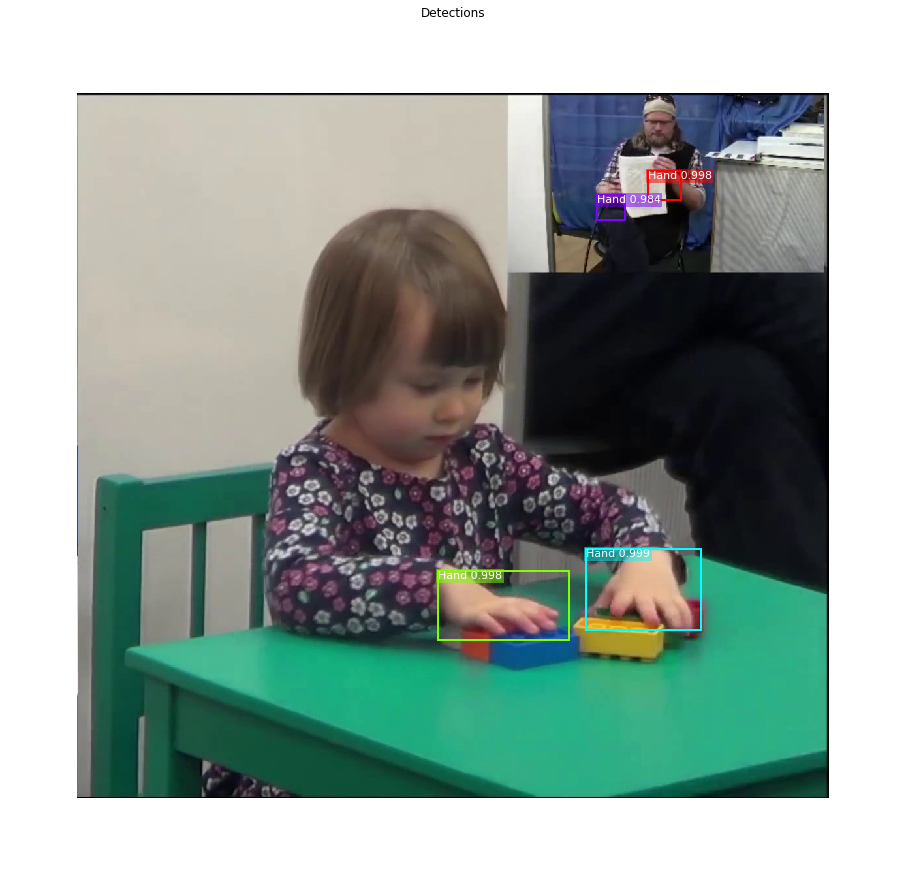

In [122]:
# Get detection class IDs. Trim zero padding.
class_names = ("BG","Hand")
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]

print(captions)
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[1] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [145]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = utils.denorm_boxes(mrcnn['proposals'][0], image.shape[:2])
# proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w]))#.astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
53 Positive ROIs
[('BG', 947), ('Hand', 53)]


[ 1 27 14 32  1 47 49 33 31  4 12 37 26 44 26 37 26 43 46 37 28  7 11  1
  1 12 45 45 11 29  3 10 18 21  1  9 40 23 43 34 49 13 40 33 11 22 18 43
  4  2]


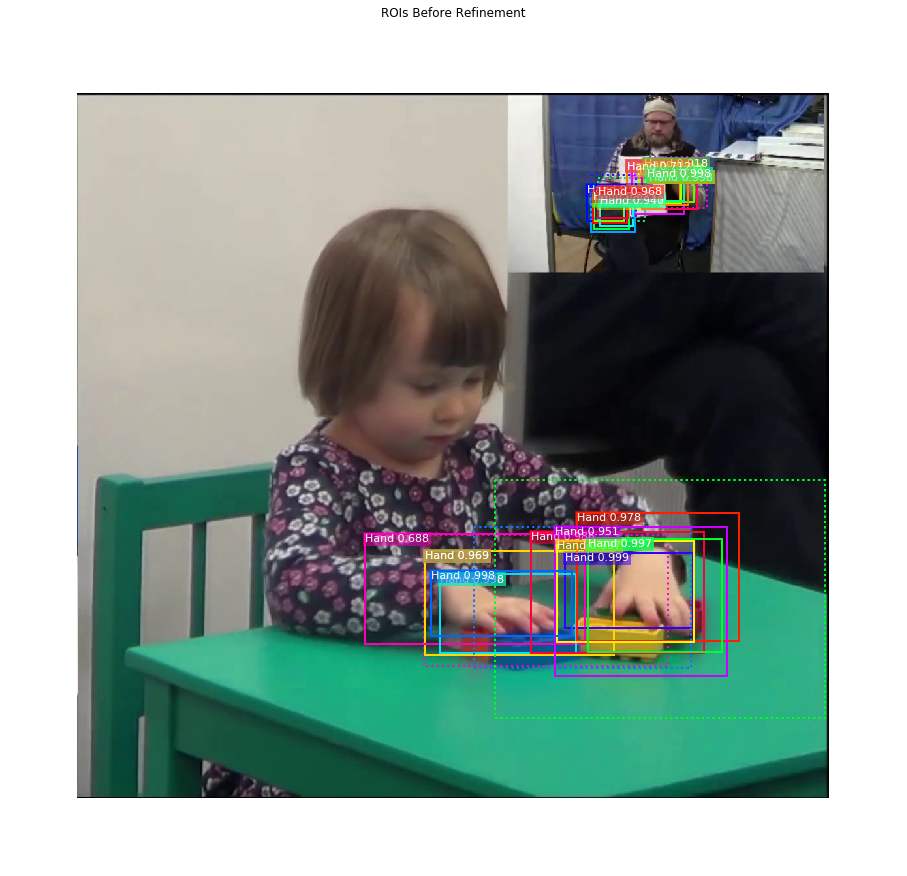

In [160]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
print(ixs)
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [175]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)#.astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 20
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

NameError: name 'roi_boxes' is not defined

#### Filter Low Confidence Detections

In [151]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 53 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  38  41  43  46  54  55  60  61  62  65  87  88  94 181 242 573]


In [152]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 48:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  38  41  43  54  55  60  61  62  65  87  94 242]


#### Per-Class Non-Max Suppression

In [153]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Hand                  : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  38  41  43  54  55  60  61  62  65  87  94 242] -> [ 7  2  1 20]

Kept after per-class NMS: 4
[ 1  2  7 20]


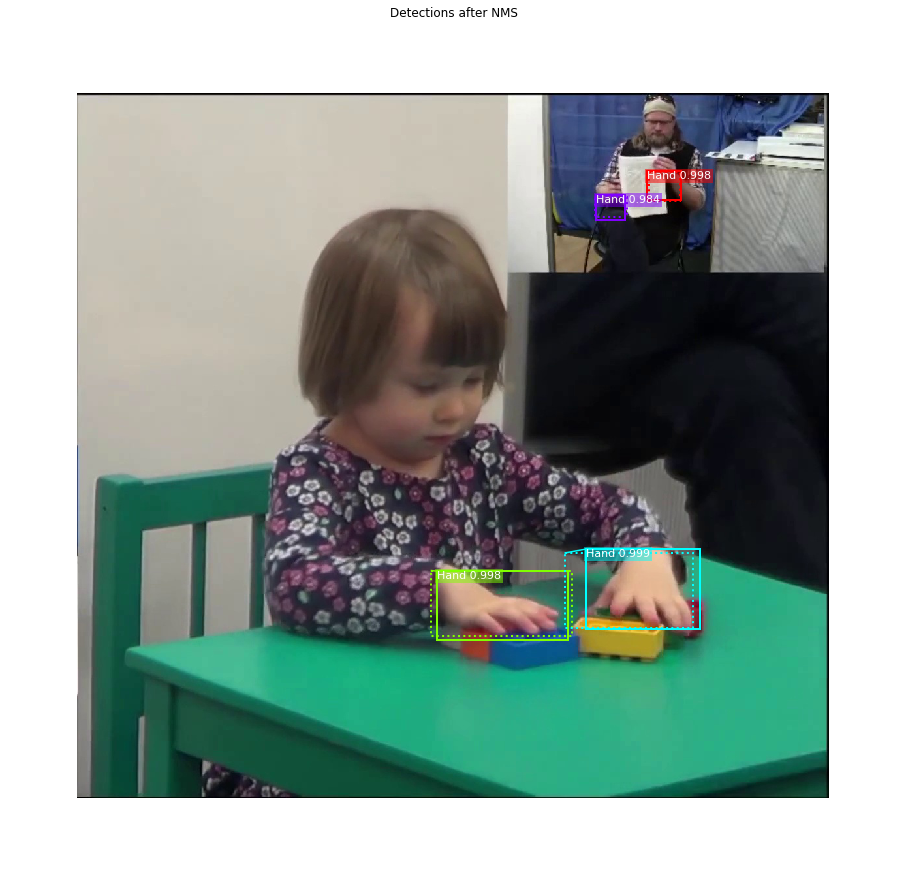

In [154]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.b Predicted Masks

In [112]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

4 detections: ['Hand' 'Hand' 'Hand' 'Hand']


In [113]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

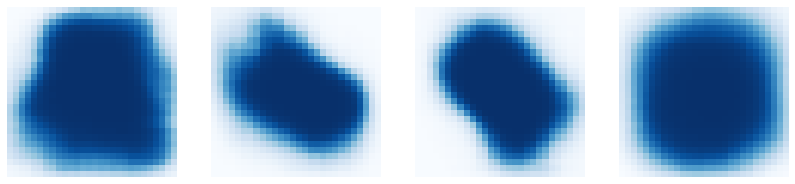

In [114]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

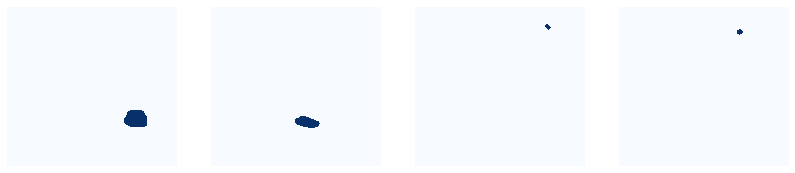

In [115]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [142]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

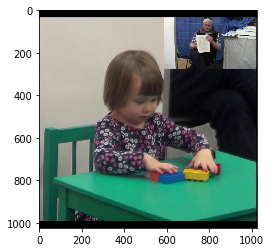

In [143]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

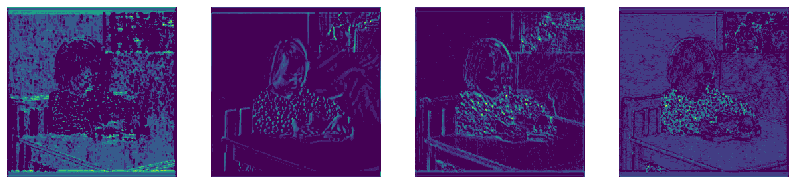

In [144]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)